In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
from networkx.algorithms.community import (
    k_clique_communities,
    louvain_communities,
)
from networkx import edge_betweenness_centrality as betweenness
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
sf_df = pd.read_csv('../data/software/Digital_Software_v1_00.tsv', sep='\t')

In [3]:
sf_df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,17747349,R2EI7QLPK4LF7U,B00U7LCE6A,106182406,CCleaner Free [Download],Digital_Software,4,0,0,N,Y,Four Stars,So far so good,2015-08-31
1,US,10956619,R1W5OMFK1Q3I3O,B00HRJMOM4,162269768,ResumeMaker Professional Deluxe 18,Digital_Software,3,0,0,N,Y,Three Stars,Needs a little more work.....,2015-08-31
2,US,13132245,RPZWSYWRP92GI,B00P31G9PQ,831433899,Amazon Drive Desktop [PC],Digital_Software,1,1,2,N,Y,One Star,Please cancel.,2015-08-31
3,US,35717248,R2WQWM04XHD9US,B00FGDEPDY,991059534,Norton Internet Security 1 User 3 Licenses,Digital_Software,5,0,0,N,Y,Works as Expected!,Works as Expected!,2015-08-31
4,US,17710652,R1WSPK2RA2PDEF,B00FZ0FK0U,574904556,SecureAnywhere Intermet Security Complete 5 De...,Digital_Software,4,1,2,N,Y,Great antivirus. Worthless customer support,I've had Webroot for a few years. It expired a...,2015-08-31


In [4]:
sf_df.nunique()

marketplace               1
customer_id           94099
review_id            101836
product_id             2995
product_parent         2981
product_title          2639
product_category          1
star_rating               5
helpful_votes           283
total_votes             290
vine                      1
verified_purchase         2
review_headline       69680
review_body           98420
review_date            2198
dtype: int64

In [5]:
# Create a dictionary from train data
# key -> product
# value -> concatenated reviews by various users for the product
# Finally extract list of unique produccts and concatenated reviews from the dictionary
product_reviews_dict = {}
for index, row in sf_df.iterrows():
    if row['product_id'] in product_reviews_dict:
        product_reviews_dict[row['product_id']] = product_reviews_dict[row['product_id']] + " " + str(row['review_body'])
    else:
        product_reviews_dict[row['product_id']] = row['review_body']
products_list = list(product_reviews_dict.keys())
reviews_list = list(product_reviews_dict.values())

In [6]:
# Tokenize the review text using CountVectorizer to create a document term matrix (product vs words in review)
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(reviews_list)

In [7]:
# Reduce the dimensionality of document term matrix
n_components = [num for num in range(200,2500, 100)]
explained_variance = {}

for n in n_components:
    svd = TruncatedSVD(n_components=n, n_iter=5)
    X_red = svd.fit_transform(X)
    explained_variance[n] = svd.explained_variance_ratio_.sum()

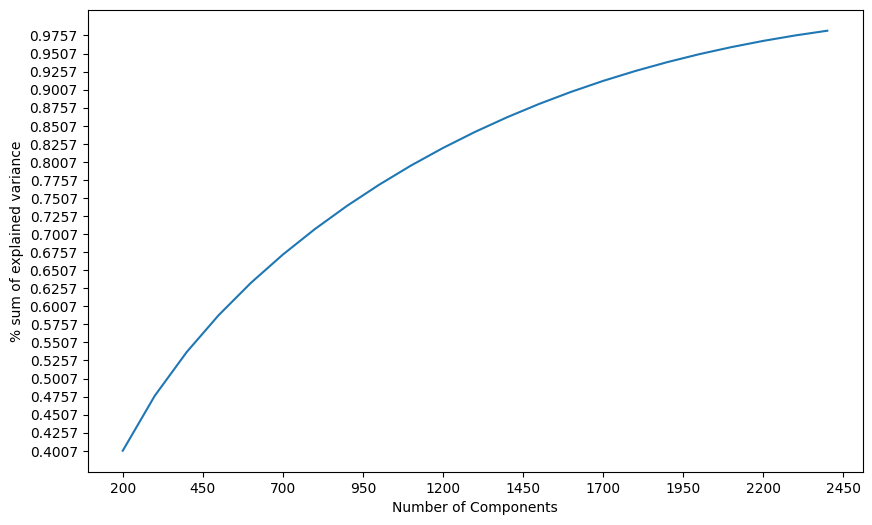

In [8]:
plt.figure(figsize=(10,6))
plt.plot(n_components, list(explained_variance.values()))
plt.xticks(np.arange(min(n_components), max(n_components)+100, 250))
plt.yticks(np.arange(min(explained_variance.values()), max(explained_variance.values()), 0.025))
plt.xlabel("Number of Components")
plt.ylabel("% sum of explained variance")
plt.show()

In [9]:
# Reduce the dimensionality of document term matrix
svd = TruncatedSVD(n_components=2200, n_iter=10)
X_red = svd.fit_transform(X)
X_red.shape

(2995, 2200)

In [10]:
# Create an adjacency matrix for graph using kneighbors_graph with speciefied number of neighbors
X_graph_adj = kneighbors_graph(X_red, 15, mode='distance', n_jobs=-1)

In [11]:
# Create a networkX graph from the adjacency matrix
main_graph = nx.convert_matrix.from_scipy_sparse_array(X_graph_adj)

# Create a label mapping between products and indices created in the graph
label_mapping = dict(zip(main_graph.nodes(), products_list))

# Relabel the indices in the graph with product names 
main_graph = nx.relabel_nodes(main_graph, label_mapping)
print(main_graph)

Graph with 2995 nodes and 38733 edges


In [12]:
# function to calculate pagerank for the nodes in a community within a graph
def getPageRankOfCommunity(G, community_nodes):
    community_graph = G.subgraph(community_nodes)
    return nx.pagerank(community_graph, alpha=0.85, weight='weight')

In [13]:
# Instanciate K-Clique algorithm and get the communities 
k_clique = k_clique_communities(main_graph, 8)

# Transform the communities obtained into a dictionary with
# key -> communityId
# value -> list of nodes in the community
kc_dict = dict(enumerate(k_clique))

print(kc_dict)

{0: frozenset({'B00JXQAOMG', 'B009NVU5OS', 'B00JXQ7596', 'B00LU2XR8E', 'B00JXQ70DC', 'B00LU3EY2Q', 'B00LU2XM0C', 'B00V50L4AO', 'B00JXQBG82', 'B00LU2XOLO', 'B00HY2Y5IU', 'B00JXQ72V2', 'B00LU2XHAC', 'B00QMQL2NK', 'B00J04F9LW', 'B00CLIIF0G', 'B00JXQ6XQM', 'B00JXQ65JW', 'B005UHJYYQ', 'B00QU5KWAW'}), 1: frozenset({'B009NVU5OS', 'B009NVTQ6G', 'B00H58C0VW', 'B00FQT8ENA', 'B009NVU9JE', 'B00FZ0FVSG', 'B006IYQBAK', 'B006IYQBSW', 'B00HY2Y5IU', 'B00FQT6SQU', 'B009NVU7Y6', 'B0073KZLMC', 'B006IYQAT2', 'B00H586KXQ', 'B00FZ0FK0U', 'B00H58LBL2', 'B006IYQACY', 'B00FQT875A'}), 2: frozenset({'B00E7XAZ88', 'B008S0IZ6K', 'B002PDPIIE', 'B00MEUQJKO', 'B005HYIEM0', 'B00MEUQYV8', 'B008S0J03W', 'B002PDPIK2', 'B003PDMNBS', 'B00E7XAJVG', 'B00E7XAWAY', 'B00OVT6VKY', 'B00QZ0NILC', 'B002PDPIJI', 'B005HYIH2M', 'B00E7XA7KY', 'B00MFYBSEQ', 'B00E7XANU8', 'B008KNYHTO', 'B00NGXMC3G', 'B003ZK51ZQ', 'B00MEUQF9O', 'B005HYIFVA', 'B009L67I7C', 'B00MEUQOQS', 'B003ZK521E', 'B00E7XB5LY', 'B003ZK51Z6', 'B00E7XA2UE', 'B00MEUQACQ', '

In [14]:

# Create a dictionary with
# key -> product
# value -> Id of the community the product belongs to
kc_product_comm_dict = {}
for comm, products in kc_dict.items():
    for product in products:
        kc_product_comm_dict[product] = comm

# Calculate pagerank for the nodes in each community and create a dictionary where
# key -> communityId
# value -> list of tuples (product, pagerank) sorted in descending order of pagerank
kc_community_pagerank_dict = {}
for comm, nodes in kc_dict.items():
    page_rank_dict = getPageRankOfCommunity(main_graph, nodes)
    kc_community_pagerank_dict[comm] = sorted(page_rank_dict.items(), key=lambda kv: kv[1], reverse=True)
# print(kc_community_pagerank_dict)

In [15]:
# function to return the recommendation of a product using the communities specified
# product_comm_dict and community_pagerank_dict can be results of any community detection alorithm (K-clique or girvan-newman)
def getProductRecommendations(product, product_comm_dict, community_pagerank_dict):
    if product in product_comm_dict:
        recommendation_list = []
        comm_nodes = community_pagerank_dict[product_comm_dict[product]]
        comm_nodes = [(p, pr*cosine_similarity(X_red[list(products_list).index(p)].reshape(1,-1), X_red[list(products_list).index(product)].reshape(1,-1))) for p, pr in comm_nodes]
        comm_nodes = sorted(comm_nodes, key=lambda kv: kv[1], reverse=True)
        for product_id, pagerank in comm_nodes:
            if len(recommendation_list) >= 5:
                break
            elif product_id != product:
                recommendation_list.append(product_id)
            else:
                continue
        return recommendation_list
    else:
        return []

In [16]:
train_df, test_df = train_test_split(sf_df, test_size=0.02)

In [17]:
test_df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
64690,US,38215593,R1VX5VVWYOOZO5,B002Q2TTIO,771732501,Garmin nuMaps Lifetime North America Map Updates,Digital_Software,5,0,0,N,Y,Lifetime updates not all that great,I got this after driving to the Omaha zoo and ...,2014-02-27
96423,US,31512982,R1C2OI04DS315Q,B005S4Y65I,366848529,TurboTax Premier Federal + E-file + State 2011...,Digital_Software,4,0,0,N,Y,Turbotax,After many failed attempts and research on the...,2012-04-11
35556,US,52819784,R1HJHLGMC9LT2P,B00NNZNTAC,797325938,Photoshop Elements 13,Digital_Software,5,0,0,N,Y,Great,So far I love it. Takes some getting used to ...,2014-12-30
94574,US,41580653,R111VU68PU5WEA,B006IYQAT2,626608997,Webroot SecureAnywhere Essentials 2012 3PC [Do...,Digital_Software,4,0,0,N,Y,Repeat purchase,I purchased Webroot a year ago to protect my c...,2012-10-02
76811,US,9412758,R2S75SLTYZD8R8,B009VI8E82,302765791,Microsoft Windows 8 Pro Pack (Win 8 to Win 8 P...,Digital_Software,5,0,0,N,Y,my software,work perfectly on my first computer no problem...,2013-10-12


In [18]:
def getRecommendedProductNames(recommendations, original_df):
    recommended_product_names = []
    for product_id in recommendations:
        recommended_product_names.append((original_df[original_df['product_id'] == product_id]['product_title'].iloc[0], product_id))
    return recommended_product_names

In [19]:
with open('../data/software/recommendations_kc_8_k15.txt', 'w') as f:
    for index, row in test_df.iterrows():
        recommendations = getProductRecommendations(row['product_id'], kc_product_comm_dict, kc_community_pagerank_dict)
        rec_products = getRecommendedProductNames(recommendations, sf_df)
        f.write(f"Recommended items for Product: {row['product_title']} - {row['product_id']} are {rec_products} \n")

In [22]:
pos = nx.spring_layout(main_graph)

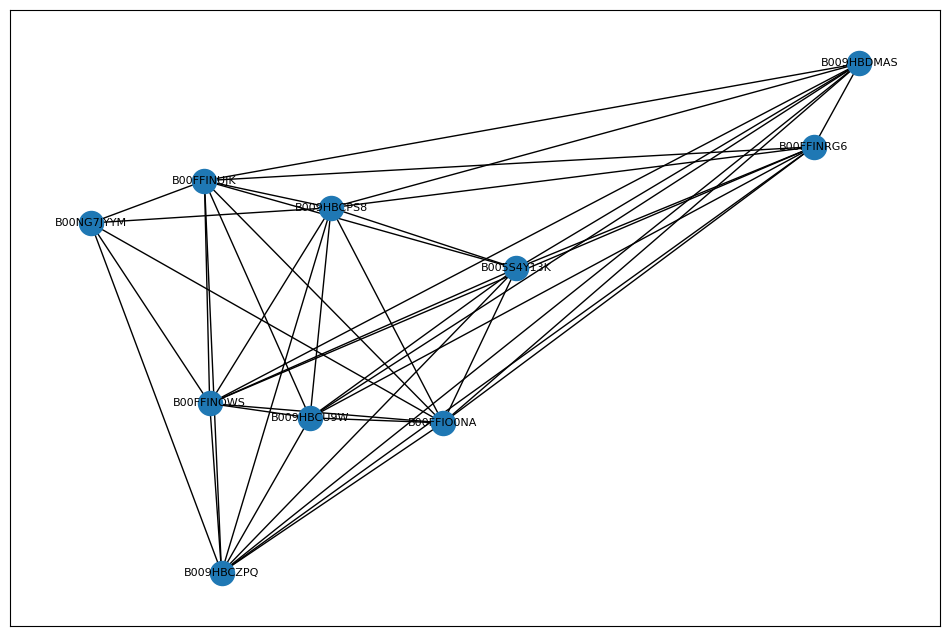

In [23]:
res = ['B00FFINOWS', 'B00NG7JYYM', 'B005S4Y13K', 'B00FFIO0NA', 'B009HBCU9W', 'B00FFINRG6', 'B009HBDMAS', 'B009HBCZPQ','B00FFINUJK', 'B009HBCPS8']
k = main_graph.subgraph(res)
plt.figure(figsize=(12, 8))
sub = nx.draw_networkx(k, pos=pos,font_size=8)

In [24]:
relabel = {}
for product_id in sf_df['product_id'].unique():
    relabel[product_id] = sf_df[sf_df['product_id'] == product_id]['product_title'].iloc[0]

In [25]:
new_graph = nx.relabel_nodes(main_graph, relabel)

In [26]:
new_graph.remove_edges_from(nx.selfloop_edges(new_graph))

In [27]:
new_pos = nx.spring_layout(new_graph)

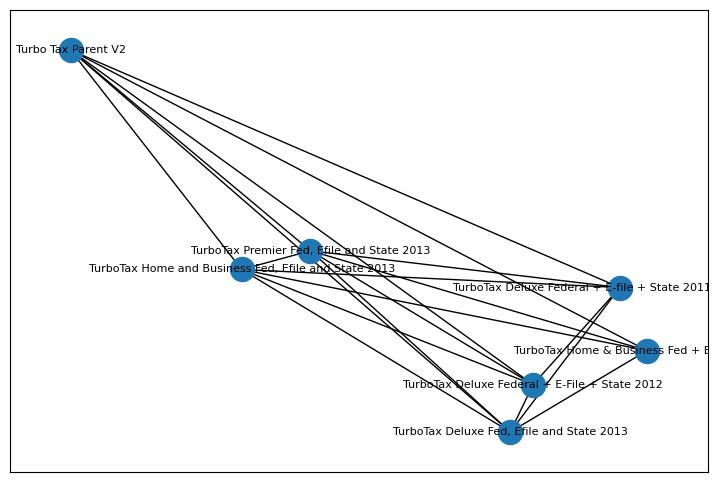

In [28]:
new_k = nx.relabel_nodes(k, relabel)
new_k.remove_edges_from(nx.selfloop_edges(new_k))
plt.figure(figsize=(9, 6))
nx.draw_networkx(new_k, pos=new_pos,font_size=8)